In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import csv
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
#img = get_image('img_align_celeba/182671.jpg')
#plt.imshow(img)
def get_input_transform():
    
    custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])                                      
     

    return custom_transform

def get_input_tensors(img):
    transf = get_input_transform()
    input_tensor = transf(img).unsqueeze(0)
    input_tensor = input_tensor.to(DEVICE)
    # unsqeeze converts single image to batch of 1
    return input_tensor

In [3]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 128
DEVICE = 'cuda:0' # default GPU device
#DEVICE = 'cpu'
GRAYSCALE = False

Let's load the pretrained model 


In [4]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model


In [5]:
torch.manual_seed(1)
GRAYSCALE=False

model = resnet101(2, GRAYSCALE)
model.load_state_dict(torch.load('/home/constanza/tfg/TFG/thesis/model_attractiveness.pth'))
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
#Store names of the images and tags
idx2label, cls2label, cls2idx = [], {}, {}

file_path = 'parsed_files/celeba-attractiveness-test.csv'

with open(os.path.abspath(file_path), 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        image_name, label,part = line.strip().split(',')
        idx2label.append(image_name)
        cls2label[image_name] = int(label)
        cls2idx[image_name] = len(idx2label) - 1


In [7]:
def get_top_predictions(logits, idx2label):
    softmax_output = logits[1]
    pred_class = torch.argmax(softmax_output, dim=1).item()
    pred_prob = softmax_output[:, pred_class].item()
    # Returns the probability of the class and the predicted class
    return pred_prob, pred_class



In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.CenterCrop((178, 178)),
        transforms.Resize((128, 128))
    ])  

    return transf

def get_preprocess_transform():    
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf   



pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()



In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)
    batch = batch.to(DEVICE)
    
    logits = model(batch)
    softmax_output = logits[1]
    probs = F.softmax(softmax_output, dim=1)
    return probs.detach().cpu().numpy()

Once we have loaded the model and compiled the functions inside the explainer we will start to generate the heatmaps
We are going to load the images used to 


In [10]:
import lime_image
explainer = lime_image.LimeImageExplainer()


In [11]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable  


def assign_color(importance, scores, pred_class):
    colors_positive = []
    colors_negative = []

    i=0
    for segment_id in importance:
        maxi= scores[pred_class][0]
        score = scores[pred_class][i]
        if score>=0:
            score = scores[0][i]/maxi # Importance of each segment
            color_intensity = abs(score)  # Absolute value as intensity 
            colors_positive.append(color_intensity)  
            colors_negative.append(0)
        else:
            score = scores[0][i]/maxi
            color_intensity = abs(score)  
            colors_negative.append(color_intensity)
            colors_positive.append(0)
        i=i+1
    return (colors_positive, colors_negative)

def show_segmented_image_with_intensity(segments, importance_order, intensity_values, positive, img_id):
    # Create a matrix based on relevance and intensity
    num_segments = len(importance_order)
    colors = np.zeros((segments.shape[0], segments.shape[1], 4))  # RGBA colors
    
    
    norm = Normalize(vmin=min(intensity_values), vmax=max(intensity_values))
    if positive:
        cmap = plt.cm.Blues
    else:
        cmap = plt.cm.Reds

    intensity_colors = cmap(norm(intensity_values))
    
    
    for segment_id, importance in zip(importance_order, intensity_colors):
        segment_mask = (segments == segment_id)
        colors[segment_mask] = importance
    
    
    fig, ax = plt.subplots(figsize=(8, 8))
    print(ax)
    im = ax.imshow(colors)
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('Relevance to prediction')
    plt.axis('off')
    #uncomment this section if you want to store the explanation
    #rute = "segmentations/fp_explanations/" + img_id
    #fig.savefig(rute, dpi=128)
    plt.show()
    



Let's do one example to see what is suposed to generate

In [12]:
img = get_image('img_align_celeba/182680.jpg')
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
print(logits)
prob, pred_class = get_top_predictions(logits, idx2label)
print("Probability:", prob)
print("Predicted class:", pred_class)
print("True class:", cls2label['182680.jpg'])

(tensor([[ 0.1527, -0.1603]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.5776, 0.4224]], device='cuda:0', grad_fn=<SoftmaxBackward0>))
Probability: 0.5776184797286987
Predicted class: 0
True class: 1


In [13]:
import lime_image
explainer = lime_image.LimeImageExplainer()
explanation, scores, prob, imp, seg = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
#print(scores)

print(prob)

0.5167064423117332


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4865755562190181, 0, 0, 0, 0, 0, 0, 0, 0, 0.46077771394314754, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2941727386035498, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28678664621058725, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2704366442732942, 0, 0.2614701679105939, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2458643200248517, 0, 0, 0, 0, 0, 0, 0.23099697447453316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20811229080515598, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16013104131039912, 0, 0.

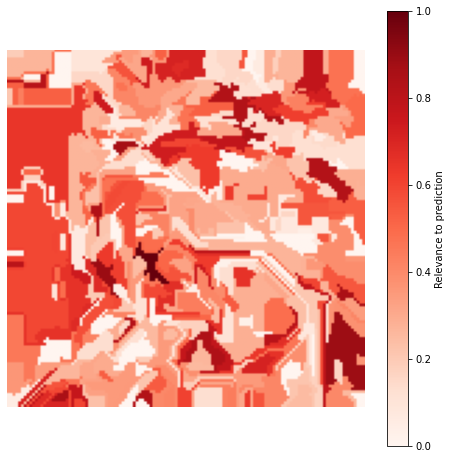

In [16]:
colors_p, colors_n = assign_color(imp, scores,pred_class)
print(colors_p)
print(colors_n)
show_segmented_image_with_intensity(seg, imp, colors_n,False,'182640.jpg')

We are going to program a loop in order to recognize what areas of the images classifies as false negatives lead to the missclasification

  0%|          | 0/1000 [00:00<?, ?it/s]

AxesSubplot(0.125,0.125;0.775x0.755)


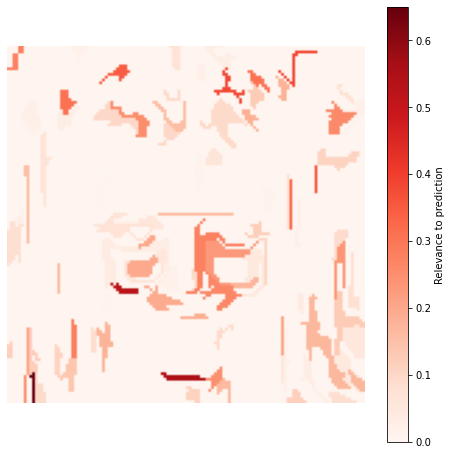

  0%|          | 0/1000 [00:00<?, ?it/s]

AxesSubplot(0.125,0.125;0.775x0.755)


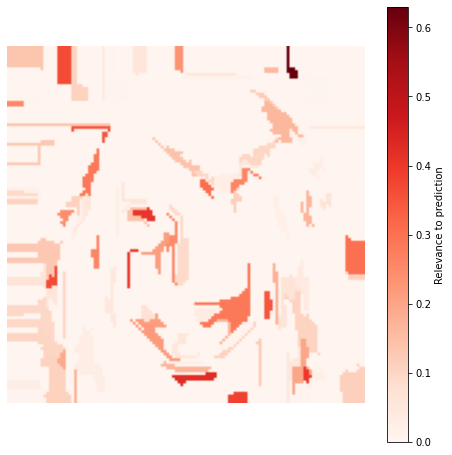

  0%|          | 0/1000 [00:00<?, ?it/s]

AxesSubplot(0.125,0.125;0.775x0.755)


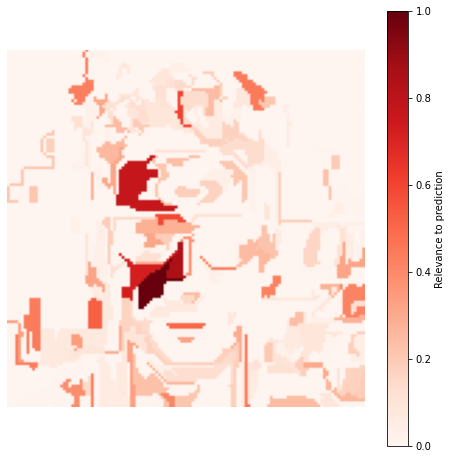

  0%|          | 0/1000 [00:00<?, ?it/s]

AxesSubplot(0.125,0.125;0.775x0.755)


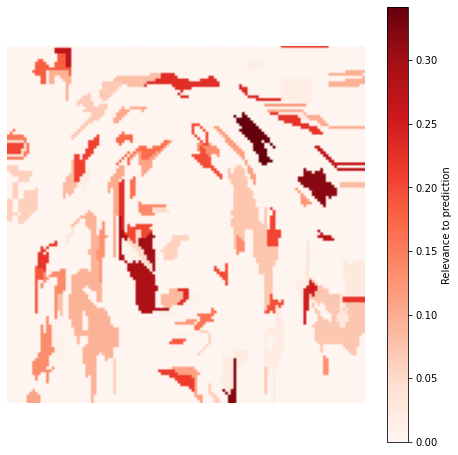

Acc: 0.8
False positive:  0
False negative:  4
True Positive:  3
True negative:  13


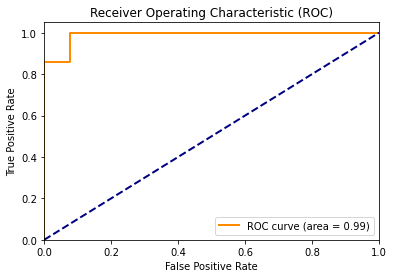

AUC: 0.989010989010989


In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
fn = 0
fp = 0
y_true = []
y_scores = []

with open('parsed_files/celeba-attractiveness-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        img_id =linea[0]
        path_total = os.path.join(nueva_imagen, img_id)
        tl = img_id.split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob, pred_class = get_top_predictions(logits, idx2label)
        
        if pred_class==1 and cls2label[img_id]==1:
            tp = tp+1
        if pred_class==0 and cls2label[img_id]==0:
            tn = tn+1
        if pred_class==0 and cls2label[img_id]==1:
            fn = fn+1
            explanation, scores, prob, imp, seg = explainer.explain_instance(np.array(pill_transf(img)), 
                                                     batch_predict, # classification function
                                                     top_labels=2, 
                                                     hide_color=0, 
                                                     num_samples=1000)
            colors_p, colors_n = assign_color(imp, scores,pred_class)
            show_segmented_image_with_intensity(seg, imp, colors_p,False, img_id)
        if pred_class==1 and cls2label[img_id]==0:
            fp = fp+1
           
        if pred_class==0:
            prob = 1-prob
            
        y_true.append(cls2label[img_id])
        y_scores.append(prob)

        if lim==20:
            break
            
print("Acc:", (tp+tn)/lim)
print("False positive: ", fp)
print("False negative: ", fn)
print("True Positive: ", tp)
print("True negative: ", tn)
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print("AUC:", roc_auc)

In [ ]:
import cv2
import numpy as np
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def overlay_images(images):
    # Inicializar una imagen en blanco del mismo tamaño que las imágenes originales
    combined_image = np.zeros_like(images[0])
    
    # Superponer cada imagen sobre la imagen combinada
    for img in images:
        combined_image += img
    
    # Normalizar la imagen combinada
    combined_image = cv2.normalize(combined_image, None, 0, 255, cv2.NORM_MINMAX)
    
    return combined_image

folder_path = '/home/constanza/tfg/TFG/thesis/segmentations/fn_explanations'
images = load_images_from_folder(folder_path)

if len(images) > 0:
    combined_image = overlay_images(images)
    cv2.imshow('Combined Image', combined_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No se encontraron imágenes en la carpeta especificada.")


Acc: 0.875
False positive:  0
False negative:  1
True Positive:  2
True negative:  5


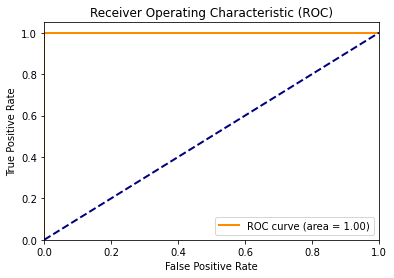

AUC: 1.0


In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
fn = 0
fp = 0
y_true = []
y_scores = []

with open('parsed_files/celeba-attractiveness-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        img_id =linea[0]
        path_total = os.path.join(nueva_imagen, img_id)
        tl = img_id.split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob, pred_class = get_top_predictions(logits, idx2label)
        
        if pred_class==1 and cls2label[img_id]==1:
            tp = tp+1
        if pred_class==0 and cls2label[img_id]==0:
            tn = tn+1
        if pred_class==0 and cls2label[img_id]==1:
            fn = fn+1
        if pred_class==1 and cls2label[img_id]==0:
            fp = fp+1
            explanation, scores, prob, imp, seg = explainer.explain_instance(np.array(pill_transf(img)), 
                                                     batch_predict, # classification function
                                                     top_labels=2, 
                                                     hide_color=0, 
                                                     num_samples=1000)
            colors_p, colors_n = assign_color(imp, scores,pred_class)
            show_segmented_image_with_intensity(seg, imp, colors_p,False, img_id)
           
        if pred_class==0:
            prob = 1-prob
            
        y_true.append(cls2label[img_id])
        y_scores.append(prob)

        if lim==8:
            break
            
print("Acc:", (tp+tn)/lim)
print("False positive: ", fp)
print("False negative: ", fn)
print("True Positive: ", tp)
print("True negative: ", tn)
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print("AUC:", roc_auc)